In [1]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

import json
import pathlib
import pandas as pd
import mongomock
import xarray as xr
import cv2
from scipy import signal
import numpy as np
from fsspec.implementations.local import LocalFileSystem
from fsspec.implementations.dirfs import DirFileSystem
from pathlib import Path
import matplotlib.pyplot as plt
from signalstore import UnitOfWorkProvider


ModuleNotFoundError: No module named 'cv2'

In [3]:
# Functions

def deserialize_dataarray(data_object):
        """Deserializes a data object.
        Arguments:
            data_object {dict} -- The data object to deserialize.
        Returns:
            dict -- The deserialized data object.
        """
        attrs = data_object.attrs.copy()
        for key, value in attrs.items():
            if isinstance(value, str):
                value = value.replace("'", '"')
                if value.lower() == 'true':
                    attrs[key] = True
                elif value.lower() == 'false':
                    attrs[key] = False
                elif value.lower() == 'none':
                    attrs[key] = None
                elif value.startswith('{'):
                    attrs[key] = json.loads(value)
            if isinstance(value, np.ndarray):
                attrs[key] = value.tolist()
        data_object.attrs = attrs
        return data_object


In [4]:
# Mock DB client
mongo_client = mongomock.MongoClient()

# Demo filesystem
tmpdir =  Path.cwd().parent / r"data" / r"internal"
tmpdir = pathlib.Path(tmpdir) # we can use UPath if we want to emulate a Path for a cloud or HTTPS based file system
og_filesystem = LocalFileSystem() # we can use any fsspec filesystem, including Google Cloud, Amazon Web Services, etc.
filesystem = DirFileSystem(tmpdir, og_filesystem)
# clear tmpdir
for file in filesystem.ls(tmpdir):
    filesystem.rm(file)

# Empty memory store for demo
memory_store = dict()

# Get uow to act on database
uow_provider = UnitOfWorkProvider(mongo_client, filesystem, memory_store)
unit_of_work = uow_provider(str(tmpdir))

# Get raw_property_models
property_models_path = Path.cwd().parent / r"tests" / r"data" / r"valid_data" / r"models" / r"property_models.json"
with open(property_models_path, 'r') as file:
    raw_property_models = json.load(file)

# Get raw_metamodels
metamodels_dir = Path.cwd().parent / r"tests" / r"data" / r"valid_data" / r"models" / r"metamodels"
metamodel_filepaths = list(metamodels_dir.glob("*.json"))
raw_metamodels = []
for filepath in metamodel_filepaths:
    with open(filepath, 'r') as file:
        raw_metamodels.append(json.load(file))

# Get raw_data_models
data_models_dir = Path.cwd().parent / r"tests" / r"data" / r"valid_data" / r"models" / r"data_models"
data_model_filepaths = list(data_models_dir.glob("*.json"))
raw_data_models = []
for filepath in data_model_filepaths:
    with open(filepath, 'r') as file:
        raw_data_models.append(json.load(file))

# Get raw_records
netcdf_dir = Path.cwd().parent / r"data" / r"input"


records_files = list(netcdf_dir.glob("*.xlsx"))
raw_records = []
for filepath in records_files:
        file = pd.read_excel(filepath, engine='openpyxl', dtype=str)
        file_json = file.to_json(orient="records")
        records = json.loads(file_json)
        raw_records.extend(records)

# Get dataarrays
netcdf_dir = Path.cwd().parent / r"data" / r"input"
netcdf_files = list(netcdf_dir.glob("*.nc"))
dataarrays = []
for filepath in netcdf_files:
    dataarray = xr.open_dataarray(filepath)
    dataarray = deserialize_dataarray(dataarray)
    dataarrays.append(dataarray)

# Add property models, metamodels, data models, and records
with unit_of_work as uow:
    for property_model in raw_property_models:
        uow.domain_models.add(property_model)
    for metamodel in raw_metamodels:
        uow.domain_models.add(metamodel)
    for data_model in raw_data_models:
        uow.domain_models.add(data_model)
    for record in raw_records:
        if not record.get("has_file"):
            uow.data.add(record)
    for dataarray in dataarrays:
        if not dataarray.attrs.get("schema_ref") == "test":
            uow.data.add(dataarray)
    uow.commit()

In [5]:
# Example query for all session records
with unit_of_work as uow:
    query = {
        "schema_ref": "session"
    }
    sorted_by = [("session_start", -1)]
    sessions = uow.data.find(query)

    for i in range(len(sessions)):
        print(sessions[i])


{'schema_ref': 'session', 'data_name': 'ANT-133a-4_20180517_133858', 'animal_id': 'ANT-133a-4', 'session_date': '2018-05-17', 'session_time': '13:38:58', 'tetrode_depth': '3150', 'stimulus_id': 'NO', 'duration': '601.0', 'duration_unit': 'second', 'stimulus_type': 'object', 'time_of_save': datetime.datetime(2024, 4, 30, 21, 11, 12, 198902), 'time_of_removal': None}
{'schema_ref': 'session', 'data_name': 'ANT-133a-4_20180517_134927', 'animal_id': 'ANT-133a-4', 'session_date': '2018-05-17', 'session_time': '13:49:27', 'tetrode_depth': '3150', 'stimulus_id': '180', 'duration': '601.0', 'duration_unit': 'second', 'stimulus_type': 'object', 'time_of_save': datetime.datetime(2024, 4, 30, 21, 11, 12, 208954), 'time_of_removal': None}
{'schema_ref': 'session', 'data_name': 'ANT-133a-4_20180517_135952', 'animal_id': 'ANT-133a-4', 'session_date': '2018-05-17', 'session_time': '13:59:52', 'tetrode_depth': '3150', 'stimulus_id': '270', 'duration': '601.0', 'duration_unit': 'second', 'stimulus_type

In [6]:
def view_query_factory(uow, query, cell_id=None, exclude=None):
    """
    Example custom use case by user to get a dictionary of xarray datasets

    Arguments:

    uow {UnitOfWork} -- Unit of work instance
    query {dict} -- Query to filter data with schema_ref and data_name as keys
    cell_id {numeric} -- Optional cell id to filter data for a single cell
    exclude {list} -- Optional list of schema_refs to exclude from query

    Outputs:

    query_dataset {dict} -- Dictionary of xarray datasets

    Example use case:

    To query across multiple sets of data and organize neural data while excluding behavioral data

    E.g. can get dictionary of multiple session with spike times/labels/waveforms organized. Can filter by session, tetrode, animal and other relevant schema.
    Can also restrict to one cell over time and exclude schema like position which are behavioral recordings.

    """
    # first get query data
    query_data = uow.data.find(query)

    # empty output dict
    session_data = {}

    # go through each schema obtained by the query
    for _, d in enumerate(query_data):

        schema_ref = d['schema_ref'] # e.g. session, animal_position, spike_times, spike_labels
        data_name = d['data_name'] # data_name is id that references schema, e.g. 'ANT-133a-4_20180517_133858' for session or '3' for probe id
        # data_names are custom ids with components determined by user to ensure unique data_names

        # custom addition to exclude schema_ref = animak_position
        # animal_position is consistent across tetrodes in a recording session and should be excluded
        # when querying neural data
        if exclude is not None and schema_ref in exclude:
                continue

        # retrieve data and add to dictionary ensuring no duplicates
        # also organizes different schema_ref with same data_name (e.g. spike times and labels for same session)
        if data_name not in session_data:
            session_data[data_name] = {}
        retrieved_data = uow.data.get(schema_ref, data_name)
        assert schema_ref not in session_data[data_name], f"Data already exists for {schema_ref} in {data_name}"
        session_data[data_name][schema_ref] = retrieved_data

    # organize sets of schema_refs into datasets for hte unique sessions collected
    # index is data_name of session
    query_dataset = {name: xr.Dataset(data) for name, data in session_data.items()}
    # query_dataset = [xr.Dataset(data) for name, data in session_data.items()]

    # optionally filter each dataset by a cell_id
    # only valid if cell_ids are matched across sessions (true in our data)
    if cell_id is not None:
        query_dataset = {name: _filter_cell_data(data, cell_id) for name, data in query_dataset.items()}

    return query_dataset

# helper fxn to only select single cell label
def _filter_cell_data(data, cell_id):
    """Get data for a single cell"""
    filtered_data = data.where(data.spike_labels == int(cell_id), drop=True)
    return filtered_data



In [7]:
""" EXAMPLE QUERIES """

# simple (single session) and complex (multi-session) queries are shown

with unit_of_work as uow:

    sample = 'ANT-133a-4_20180517_133858'

    # Single session and tetrode
    query = {
        "session_data_ref": {'schema_ref': 'session', 'data_name': sample},
        "probe_data_ref": {'schema_ref': 'probe', 'data_name': '1'}
    }
    data = view_query_factory(uow, query)
    print("single session and tetrode")
    print("Collected " + str(len(data)) + " session with " + str(len(data[next(iter(data))])) + " data variables")
    print(data[next(iter(data))].data_vars)
    ncount = len(set(list(data[next(iter(data))].spike_labels[:,0].values)))
    print("Dataset has {} cell appearances".format(ncount))

    # All sessions and single tetrode
    query = {
        "probe_data_ref": {'schema_ref': 'probe', 'data_name': '1'}
    }
    session_datasets = view_query_factory(uow, query)
    print("\nall sessions and single tetrode")
    print("Collected " + str(len(session_datasets.keys())) + " sessions with 3 data variables")
    print(session_datasets[next(iter(data))].data_vars)
    ncount = sum([len(set(list(session_datasets[session].spike_labels[:,0].values))) for session in session_datasets])
    print("Dataset has {} cell appearances".format(ncount))

    # All sessions, single tetrode and single cell
    query = {
        "probe_data_ref": {'schema_ref': 'probe', 'data_name': '1'},
    }
    session_datasets = view_query_factory(uow, query, cell_id=1)
    print("\nall sessions, single tetrode and single cell")
    print("Collected " + str(len(session_datasets.keys())) + " sessions with 3 data variables")
    print(session_datasets[next(iter(data))].data_vars)
    ncount = sum([len(set(list(session_datasets[session].spike_labels[:,0].values))) for session in session_datasets])
    print("Dataset has {} cell appearances".format(ncount))

    # Single session and all tetrodes
    query = {
        "session_data_ref": {'schema_ref': 'session', 'data_name': sample}
    }
    session_datasets = view_query_factory(uow, query, exclude=['animal_position'])
    print("\nsingle session and all tetrodes")
    print("Collected 1 sessions for " + str(len(session_datasets)) + " tetrodes with 3 data variables")
    print(session_datasets[next(iter(data))].data_vars)
    ncount = sum([len(set(list(session_datasets[session].spike_labels[:,0].values))) for session in session_datasets])
    print("Dataset has {} cell appearances".format(ncount))

single session and tetrode
Collected 1 session with 3 data variables
Data variables:
    spike_labels     (spike_idx, 1) float32 ...
    spike_times      (spike_idx, 1) float32 ...
    spike_waveforms  (spike_idx, channel, sample) float32 ...
Dataset has 9 cell appearances

all sessions and single tetrode
Collected 3 sessions with 3 data variables
Data variables:
    spike_labels     (spike_idx, 1) float32 ...
    spike_times      (spike_idx, 1) float32 ...
    spike_waveforms  (spike_idx, channel, sample) float32 ...
Dataset has 21 cell appearances

all sessions, single tetrode and single cell
Collected 3 sessions with 3 data variables
Data variables:
    spike_labels     (spike_idx, 1) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    spike_times      (spike_idx, 1) float32 0.02737 1.351 1.951 ... 599.6 599.9
    spike_waveforms  (spike_idx, channel, sample, 1) float32 0.0 0.0 ... 0.0 0.0
Dataset has 3 cell appearances

single session and all tetrodes
Collected 1 sessions for 4 tetrode

In [8]:
""" Example visualizations below """

# step 1: query (e.g. custom neural data only query)
# step 2: manipulate (e.g. organize data into 2D matrix)
# step 3: plot (e.g. feed matrix into custom/provided plot functions)

' Example visualizations below '

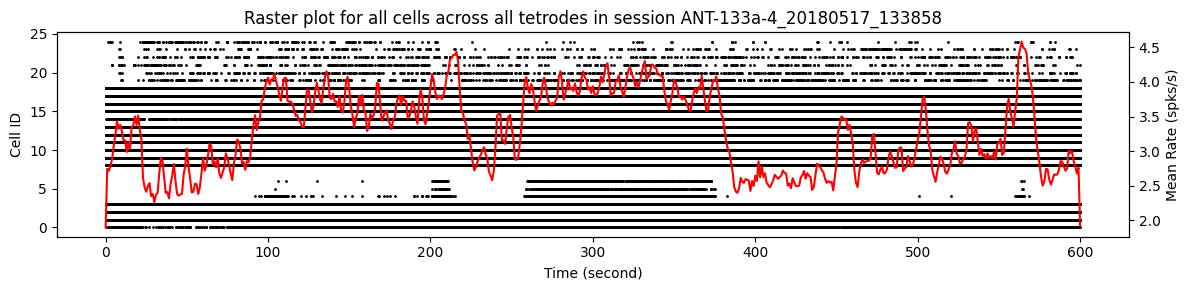

In [9]:
""" Raster plot for all cells and all tetrodes on one session """

sample = 'ANT-133a-4_20180517_133858'


# STEP #1: Get session of interest
with unit_of_work as uow:

    # query data arrays
    query = {
        "session_data_ref": {'schema_ref': 'session', 'data_name': sample},
    }
    sessions = view_query_factory(uow, query, exclude=["animal_position"])

    # query record metadata
    ses_record_query = {
        "schema_ref": "session",
        "data_name": sample
    }

    ses_record = uow.data.get(ses_record_query["schema_ref"], ses_record_query["data_name"])
    duration = ses_record["duration"]
    duration_units = ses_record["duration_unit"]

# STEP #2: Take different tetrode sessions and aggregate all cells
raster = []
# iterate through tetrode sessions
for session in sessions:
    spike_times_cluster = sessions[session].spike_times
    spike_times_cluster_indices = sessions[session].spike_labels
    # organize by cell
    for i in range(len(set(spike_times_cluster_indices[:,0].values))):
        # append single cell
        if i != 0:
            raster.append(spike_times_cluster.where(spike_times_cluster_indices == i, drop=True).values)

# STEP #3: Plot raster
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1,1,1)
for i in range(len(raster)):
    ax.scatter(raster[i], i*np.ones(len(raster[i])), s=1, c='k')

# bin spike times to make mean firing rate trace
dur = int(float(duration))
binned_raster = np.zeros((len(raster), dur))
for i in range(len(raster)):
    binned_raster[i] = np.histogram(raster[i], bins=dur)[0]
mean_firing_rate = binned_raster.mean(axis=0)
smoothed_mean_firing_rate = np.convolve(mean_firing_rate, np.ones(3)/10, mode='same')

twin_ax = ax.twinx()
twin_ax.plot(smoothed_mean_firing_rate, color='r')
twin_ax.set_ylabel("Mean Rate (spks/s)")

# ax.set_xlim(0, 200)
ax.set_xlabel("Time ({})".format(duration_units))
ax.set_ylabel("Cell ID")
ax.set_title("Raster plot for all cells across all tetrodes in session {}".format(ses_record["data_name"]))
fig.tight_layout()
plt.show()


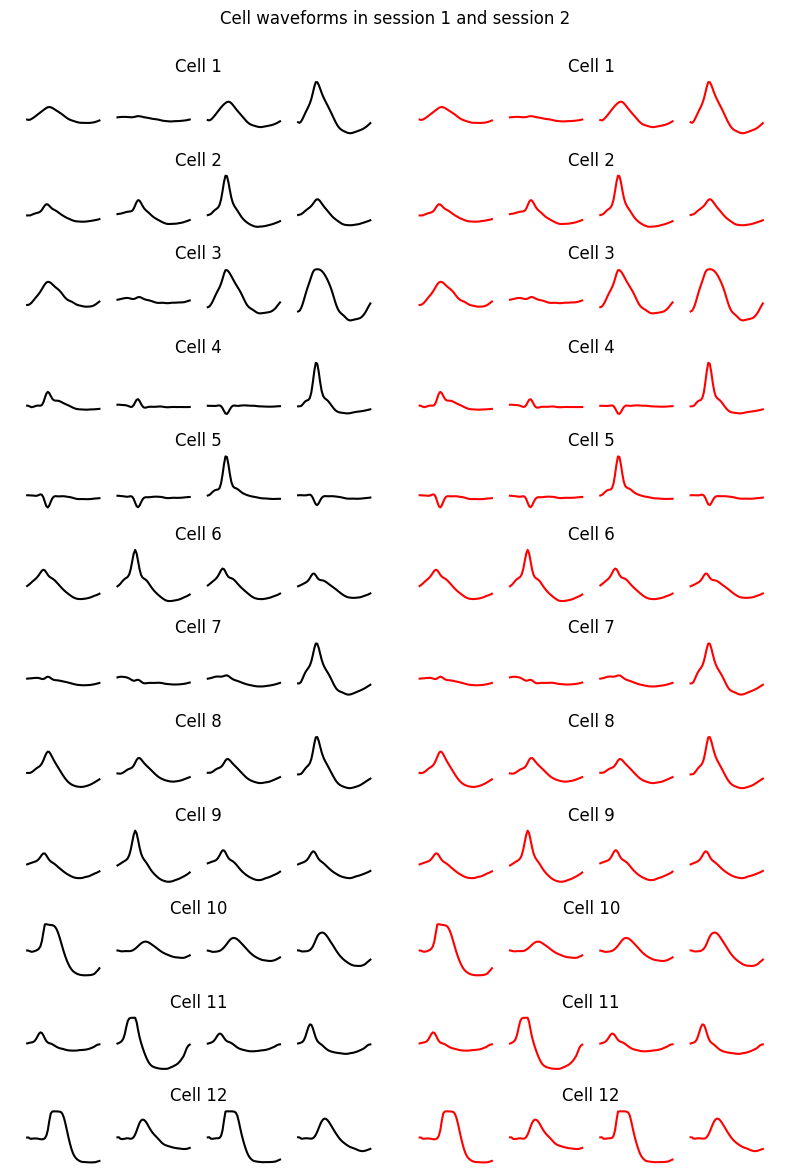

In [10]:
""" Cell waveforms for all cells in two sessions compared for one tetrode """

# STEP #1: Get first session of interest
with unit_of_work as uow:
    query = {
        "session_data_ref": {'schema_ref': 'session', 'data_name': 'ANT-133a-4_20180517_134927'},
    }
    sessions1 = view_query_factory(uow, query, exclude=["animal_position"])

    ses_record_query = {
        "schema_ref": "session",
        "data_name": "ANT-133a-4_20180517_134927"
    }

    ses_record = uow.data.get(ses_record_query["schema_ref"], ses_record_query["data_name"])
    duration1 = ses_record["duration"]
    duration_units = ses_record["duration_unit"]

# STEP #2: Get second session of interest
with unit_of_work as uow:
    query = {
        "session_data_ref": {'schema_ref': 'session', 'data_name': 'ANT-133a-4_20180517_134927'},
    }
    sessions2 = view_query_factory(uow, query, exclude=["animal_position"])

    ses_record_query = {
        "schema_ref": "session",
        "data_name": "ANT-133a-4_20180517_134927"
    }

    ses_record = uow.data.get(ses_record_query["schema_ref"], ses_record_query["data_name"])
    duration2 = ses_record["duration"]
    duration_units = ses_record["duration_unit"]

assert duration1 == duration2, "Sessions must have the same duration"

# STEP #3: Take different tetrode sessions and aggregate all cells
waveforms1 = []
# iterate through tetrode sessions
for session in sessions1:
    spike_waveforms = sessions1[session].spike_waveforms
    spike_times_cluster_indices = sessions1[session].spike_labels
    # organize by cell
    for i in range(len(set(spike_times_cluster_indices[:,0].values))):
        # append single cell
        if i != 0:
            waveforms1.append(spike_waveforms.where(spike_times_cluster_indices[:,0] == i, drop=True).values)

waveforms2 = []
# iterate through tetrode sessions
for session in sessions2:
    spike_waveforms = sessions2[session].spike_waveforms
    spike_times_cluster_indices = sessions2[session].spike_labels
    # organize by cell
    for i in range(len(set(spike_times_cluster_indices[:,0].values))):
        # append single cell
        if i != 0:
            waveforms2.append(spike_waveforms.where(spike_times_cluster_indices[:,0] == i, drop=True).values)

# STEP #3: Plot waveforms
fig = plt.figure(figsize=(8, 22))

min_len = min(len(waveforms1), len(waveforms2))
waveforms1 = waveforms1[:min_len]
waveforms2 = waveforms2[:min_len]
ccount = 1
for i in range(0, min_len, 2):
    ax1 = plt.subplot(min_len, 2, i + 1)
    ax2 = plt.subplot(min_len, 2, i + 2)

    for k in range(4):
        xpos = np.linspace(50*k + 10, 50*(k+1), 50)
        ax1.plot(xpos, np.mean(waveforms1[i][:,k,:], axis=0), label="Session 1", color='k')
        ax2.plot(xpos, np.mean(waveforms2[i][:,k,:], axis=0), label="Session 2", color='r')

        # remove xticks, yticks, labels and spines
        for ax in [ax1,ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_title("Cell {}".format(ccount))

    ccount += 1

fig.suptitle("Cell waveforms in session 1 and session 2", y=1)
fig.tight_layout()
plt.show()


In [11]:
def _extract_arena_size_from_shape(arena_record):
    """
    Custom helper function to extract arena size specifically as a tuple of
    (height, width). Also returns boolean tag to denote arena as cylinder
    or not. Both outputs are required as inputs to the ratemap functions.
    """
    shape = arena_record['arena_shape']
    unit_of_measure = arena_record['unit_of_measure']
    if shape == 'cylinder':
        diameter = float(arena_record['diameter'])
        if unit_of_measure == 'm':
            diameter *= 100
        arena_size = (diameter, diameter)
        isCylinder = True
    elif shape == 'rectangle':
        arena_height = float(arena_record['arena_height'])
        arena_width = float(arena_record['arena_width'])
        if unit_of_measure == 'm':
            arena_height *= 100
            arena_width *= 100
        arena_size = (arena_height, arena_width)
        isCylinder = False

    return arena_size, isCylinder

def flat_disk_mask(rate_map):
    masked_rate_map = disk_mask(rate_map)
    masked_rate_map.data[masked_rate_map.mask] = np.nan
    return  masked_rate_map.data

def disk_mask(matrix):
        y_segments, x_segments = matrix.shape

        y_center, x_center = (y_segments-1)/2, (x_segments-1)/2

        mask_r = min(x_segments, y_segments)/2

        mask_y,mask_x = np.ogrid[-y_center:y_segments-y_center, -x_center:x_segments-x_center]
        mask = mask_x**2 + mask_y**2 > mask_r**2

        masked_matrix = np.ma.array(matrix, mask=mask)

        return masked_matrix


In [12]:


def _speed2D(x, y, t):
    """calculates an averaged/smoothed speed"""

    N = len(x)
    v = np.zeros((N, 1))

    for index in range(1, N-1):
        v[index] = np.sqrt((x[index + 1] - x[index - 1]) ** 2 + (y[index + 1] - y[index - 1]) ** 2) / (
        t[index + 1] - t[index - 1])

    v[0] = v[1]
    v[-1] = v[-2]

    return v


def _speed_bins(lower_speed: float, higher_speed: float, pos_v: np.ndarray,
               pos_x: np.ndarray, pos_y: np.ndarray, pos_t: np.ndarray) -> tuple:

    '''
        Selectively filters position values of subject travelling between
        specific speed limits.

        Params:
            lower_speed (float):
                Lower speed bound (cm/s)
            higher_speed (float):
                Higher speed bound (cm/s)
            pos_v (np.ndarray):
                Array holding speed values of subject
            pos_x, pos_y, pos_t (np.ndarray):
                X, Y coordinate tracking of subject and timestamps

        Returns:
            Tuple: new_pos_x, new_pos_y, new_pos_t
            --------
            new_pos_x, new_pos_y, new_pos_t (np.ndarray):
                speed filtered x,y coordinates and timestamps
    '''

    # Initialize empty array that will only be populated with speed values within
    # specified bounds
    choose_array = []

    # Iterate and select speeds
    for index, element in enumerate(pos_v):
        if element > lower_speed and element < higher_speed:
            choose_array.append(index)

    # construct new x,y and t arrays
    new_pos_x = np.asarray([ float(pos_x[i]) for i in choose_array])
    new_pos_y = np.asarray([ float(pos_y[i]) for i in choose_array])
    new_pos_t = np.asarray([ float(pos_t[i]) for i in choose_array])

    return new_pos_x, new_pos_y, new_pos_t



def _spike_positions(x, y, t, spike_times, speed_bounds):

    v = _speed2D(x, y, t)
    x, y, t = _speed_bins(speed_bounds[0], speed_bounds[1], v, x, y, t)

    cPost = np.copy(t)

    N = len(spike_times)
    spike_positions_x = np.zeros((N, 1))
    spike_positions_y = np.zeros_like(spike_positions_x)
    new_spike_times = np.zeros_like(spike_positions_x)
    count = -1

    for index in range(N):

        tdiff = (t -spike_times[index])**2
        tdiff2 = (cPost-spike_times[index])**2
        m = np.amin(tdiff)
        ind = np.where(tdiff == m)[0]

        m2 = np.amin(tdiff2)
        #ind2 = np.where(tdiff2 == m2)[0]

        if m == m2:
            count += 1
            spike_positions_x[count] = x[ind[0]]
            spike_positions_y[count] = y[ind[0]]
            new_spike_times[count] = spike_times[index]

    spike_positions_x = spike_positions_x[:count + 1]
    spike_positions_y = spike_positions_y[:count + 1]
    new_spike_times = new_spike_times[:count + 1]

    return spike_positions_x.flatten(), spike_positions_y.flatten(), new_spike_times.flatten()


def get_ratemap(x, y, t, spike_times, arena_size, smoothing_factor, speed_bounds, interp_size=(64, 64), useMinMaxPos=False):
    spike_x, spike_y, _ = _spike_positions(x, y, t, spike_times, speed_bounds)
    occ_map_smoothed, occ_map_raw = _occupancy_map(x, y, t, smoothing_factor, arena_size, interp_size, useMinMaxPos)
    spike_map_smooth, spike_map_raw = _spike_map(x, y, arena_size, spike_x, spike_y, smoothing_factor, interp_size, useMinMaxPos)
    rate_map, rate_map_raw = _ratemap(occ_map_smoothed, occ_map_raw, spike_map_smooth, spike_map_raw)
    return rate_map, rate_map_raw

def _ratemap(occ_map_data, raw_occ, spike_map_data, spike_map_data_raw):
    # rate_map_raw = np.where(raw_occ<0.0001, 0, spike_map_data_raw/raw_occ)
    rate_map = np.where(occ_map_data<0.0001, 0, spike_map_data/occ_map_data)
    rate_map = rate_map/max(rate_map.flatten())

    return rate_map, _

def _spike_map(pos_x, pos_y, arena_size, spike_x, spike_y, smoothing_factor, interp_size=(64, 64), useMinMaxPos=False):
    kernlen = int(smoothing_factor * 8)
    std = int(0.2 * kernlen)

    if useMinMaxPos:
        min_x, max_x = np.min(pos_x), np.max(pos_x)
        min_y, max_y = np.min(pos_y), np.max(pos_y)
    else:
        min_x = [-arena_size[1]/2]
        max_x = [arena_size[1]/2] # width
        min_y = [-arena_size[0]/2]
        max_y = [arena_size[0]/2] # height

    row_resize, column_resize = interp_size
    spike_map_raw = np.zeros((row_resize, column_resize))
    row_values = np.linspace(max_x, min_x, row_resize)
    column_values = np.linspace(min_y, max_y, column_resize)
    row_index = np.abs(row_values[:, np.newaxis] - spike_y).argmin(axis=0)
    column_index = np.abs(column_values[:, np.newaxis] - spike_x).argmin(axis=0)
    np.add.at(spike_map_raw, (row_index, column_index), np.ones_like(row_index))
    spike_map_smooth = cv2.filter2D(spike_map_raw, -1, _gkern(kernlen, std))
    spike_map_smooth = spike_map_smooth / np.max(spike_map_smooth)
    return spike_map_smooth, spike_map_raw

def _gkern(kernlen: int, std: int) -> np.ndarray:

    '''
        Returns a 2D Gaussian kernel array.

        Params:
            kernlen, std (int):
                Kernel length and standard deviation

        Returns:
            np.ndarray:
                gkern2d
    '''

    gkern1d = signal.windows.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def _occupancy_map(x, y, t, smoothing_factor, arena_size, interp_size=(64,64), useMinMaxPos=False) -> np.ndarray:

    '''
        Computes the position, or occupancy map, which is a 2D numpy array
        enconding subjects position over entire experiment.

        Params:
            pos_x, pos_y and pos_t (np.ndarray):
                Arrays of the subjects x and y coordinates, as
                well as timestamp array.
            arena_size (tuple):
                Arena dimensions (width (x), height (y) in meters)
            resolution (float):
                Resolution of occupancy map (in meters)
            kernlen, std : kernel size and standard deviation (i.e 'spread') for convolutional smoothing
                of 2D map

            Returns:
                np.ndarray: occ_map_smoothed, occ_map_raw, coverage_map
    '''
    pos_x, pos_y, pos_t = x, y, t

    if useMinMaxPos:
        min_x = min(pos_x)
        max_x = max(pos_x)
        min_y = min(pos_y)
        max_y = max(pos_y)
    else:
        min_x = [-arena_size[1]/2]
        max_x = [arena_size[1]/2] # width
        min_y = [-arena_size[0]/2]
        max_y = [arena_size[0]/2] # height


    row_resize, column_resize = interp_size

    # Initialize empty map
    occ_map_raw = np.zeros((row_resize,column_resize))
    coverage_map = np.zeros((row_resize,column_resize))
    row_values = np.linspace(max_y,min_y,row_resize)
    column_values = np.linspace(min_x,max_x,column_resize)

    # Generate the raw occupancy map
    for i in range(1, len(pos_t)):

        row_index = np.abs(row_values - pos_y[i]).argmin()
        column_index = np.abs(column_values - pos_x[i]).argmin()
        occ_map_raw[row_index][column_index] += pos_t[i] - pos_t[i-1]

    kernlen = int(smoothing_factor*8)
    std = int(0.2*kernlen)

    occ_map_normalized = occ_map_raw / pos_t[-1]
    occ_map_smoothed = cv2.filter2D(occ_map_normalized,-1,_gkern(kernlen,std))

    kernel = np.ones((2,2))

    occ_map_smoothed = occ_map_smoothed/max(occ_map_smoothed.flatten())

    return occ_map_smoothed, occ_map_raw


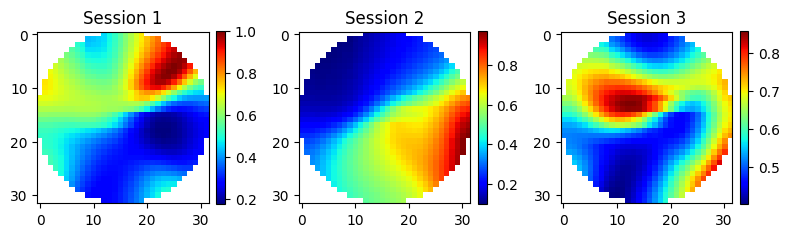

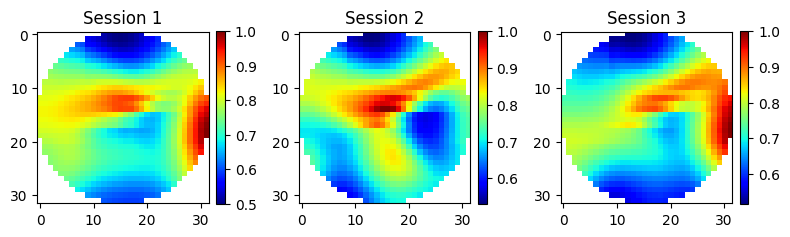

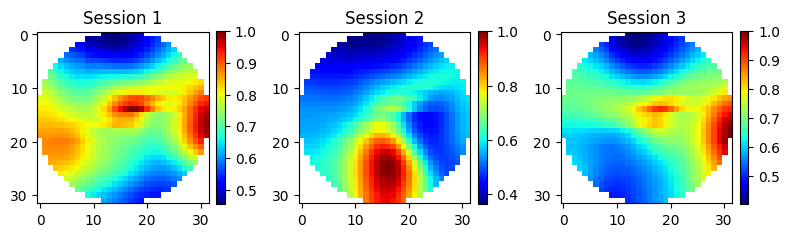

In [13]:
""" Cell ratemap for one cell on one tetrode across all sessions """

for c in range(3):


    # STEP #1: Get all sessions for the cell of interested
    with unit_of_work as uow:
        query = {
            "probe_data_ref": {'schema_ref': 'probe', 'data_name': '1'},
        }

        sessions = view_query_factory(uow, query, cell_id=c+1)

        ses_record_query = {
            "schema_ref": "session",
            "data_name": "ANT-133a-4_20180517_134927"
        }

        ses_record = uow.data.get(ses_record_query["schema_ref"], ses_record_query["data_name"])
        duration = ses_record["duration"]
        duration_units = ses_record["duration_unit"]

        arena_record_query = {
            "schema_ref": "arena",
            "data_name": "Arena1_LEC"
        }

        arena_record = uow.data.get(arena_record_query["schema_ref"], arena_record_query["data_name"])

        arena_shape = arena_record['arena_shape']
        arena_unit_of_measure = arena_record['unit_of_measure']

        # custom for custom ratemap functions
        arena_size, isCylinder = _extract_arena_size_from_shape(arena_record)

        session_position_query = {
            "schema_ref": "animal_position",
            "data_name": "ANT-133a-4_20180517_134927"
        }

        session_position = uow.data.get(session_position_query["schema_ref"], session_position_query["data_name"])

    # STEP #2: Take different tetrode sessions and aggregate all cells
    ratemaps = []
    arena_size = None
    useMinMaxPos = True
    speed_bounds = (0, 100)
    interp_size = (32,32)
    smoothing_factor = 3
    x = session_position[:,0].to_numpy().squeeze()
    y = session_position[:,1].to_numpy().squeeze()
    t = session_position[:,2].to_numpy().squeeze()
    # iterate through tetrode sessions
    for session in sessions:
        spike_times = sessions[session].spike_times.to_numpy().squeeze()

        ratemap, _ = get_ratemap(x, y, t, spike_times, arena_size, smoothing_factor, speed_bounds, interp_size=interp_size, useMinMaxPos=useMinMaxPos)
        if isCylinder:
            ratemap = flat_disk_mask(ratemap)

        ratemaps.append(ratemap)

    # STEP #3: Plot ratemaps
    fig = plt.figure(figsize=(8,3))

    for i in range(len(ratemaps)):
        ax = plt.subplot(1,len(ratemaps), i+1)

        im = ax.imshow(ratemaps[i], cmap='jet')

        ax.set_title('Session {}'.format(str(i+1)))

        fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)

    fig.tight_layout()
    plt.show()

